<div style="display: flex; align-items: center;">
    <img alt="udeA logo" height="140px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" style="width:107px;height:152px; margin-right: 40px;">
    <div style="text-align: center;">
        <h1><b><font color='0B5345'>Trabajo 1: Imagenes médicas</font></b></h1>
        <h2><font color='0B5345'>Luisa Fernanda Enciso - Juan Diego Caguasango</font></h2>
    </div>
</div>

In [1]:
import pydicom
import matplotlib.pyplot as plt
from pydicom.data import get_testdata_file
from pydicom import dcmread
import pandas as pd
from collections import defaultdict


<hr>
<h3><strong>1. Análisis de metadatos dicom y visualización</strong></h3>

**1.1.  Extraer y analizar los metadatos DICOM**


 Utilizar pydicom para extraer la metadata

In [51]:
# Ruta absoluta al archivo DICOM (puedes usar también rutas relativas si estás en el mismo directorio)
fpath = "Patient01/100/74741.4976.61812.26868.17427.42996.33493.37530.34501.100.29.dcm"

ds = dcmread(fpath) # Lectura del archivo DICOM

ds # Imprimir el contenido completo del objeto DICOM (metadatos + cabecera + estructura)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 178
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 74741.4976.61812.26868.17427.42996.33493.37530.34501.100.29
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.773
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 74741.4976.61812.26868.17427.42996.33493.37530.34501.100.29
(0008, 0020) Study Date                          DA: '20230821'
(0008, 0021) Series Date             


<h3><strong>Comfirmar Modalidad de imagen </strong></h3>

In [52]:
ds.Modality

'CT'

Se busca la metadata solicitada : 

• PatientName • Modality • SliceThickness • kVp • BodyPartExamined • Relative X-Ray Exposure • ExposureTime • Photometric Interpretation • Manufacturer • Scanner Model

In [53]:
# Extraer metadata
fields = {
    "PatientName": getattr(ds, "PatientName", None),
    "Modality": getattr(ds, "Modality", None),
    "SliceThickness": getattr(ds, "SliceThickness", None),
    "KVP": getattr(ds, "KVP", None),
    "BodyPartExamined": getattr(ds, "BodyPartExamined", None),
    "RelativeXRayExposure": getattr(ds, "RelativeXRayExposure", None),
    "ExposureTime": getattr(ds, "ExposureTime", None),
    "PhotometricInterpretation": getattr(ds, "PhotometricInterpretation", None),
    "Manufacturer": getattr(ds, "Manufacturer", None),
    "ManufacturerModelName": getattr(ds, "ManufacturerModelName", None),
}

# Mostrar resultados
for key, value in fields.items():
    if value is None or (isinstance(value, str) and value.strip() == ""):
        value = "No disponible"
    print(f"{key}: {value}")

PatientName: anonymize
Modality: CT
SliceThickness: 0
KVP: 85
BodyPartExamined: No disponible
RelativeXRayExposure: No disponible
ExposureTime: No disponible
PhotometricInterpretation: MONOCHROME2
Manufacturer: Sirona
ManufacturerModelName: No disponible


 Organizar la metadata extraída en Name, Tag, Type y Value, explique a qué hace referencia 
cada uno de ellos, el grupo al que pertenece, su relevancia y los valores válidos para ese 
metadato.

In [78]:
print("Buscamos palabras relacionadas a lo especificado: ",ds.dir('Manufac') )# Comando para buscar la data necesaria
print("Encontramos el objeto: ",ds.data_element('Manufacturer'))
print("Solo miramos el tag: ",ds.data_element('Manufacturer').tag)
print("Ahora con el tag podemos extraer la info: ",ds.get((0x0008, 0x0070))) #extrare los datos con solo el tag

Buscamos palabras relacionadas a lo especificado:  ['Manufacturer', 'ManufacturerModelName']
Encontramos el objeto:  (0008, 0070) Manufacturer                        LO: 'Sirona'
Solo miramos el tag:  (0008, 0070)
Ahora con el tag podemos extraer la info:  (0008, 0070) Manufacturer                        LO: 'Sirona'


In [55]:
tags = [
    (0x0010, 0x0010),  # Patient's Name
    (0x0008, 0x0060),  # Modality
    (0x0018, 0x0050),  # Slice Thickness
    (0x0018, 0x0060),  # KVP
    (0x0018, 0x0015),  # Body Part Examined
    (0x0028, 0x0004),  # Photometric Interpretation
    (0x0008, 0x0070),  # Manufacturer
    (0x0008, 0x1090),  # Manufacturer Model Name
]

data_list = []
for group, element in tags:
    tag = (group, element)
    data_element = ds.get(tag)
    if data_element:
        raw_value = data_element.value

        if raw_value is None or (isinstance(raw_value, str) and raw_value.strip() == ""):
            value = "No disponible"
        else:
            value = str(raw_value)

        data_list.append({
            "Name": data_element.name,
            "Tag": f"({group:04X},{element:04X})", # Formato hexadecimal
            "Type": data_element.VR,
            "Value": value,
            "Grupo": f"{group:04X}"
        })

# Colocamos los valores que no se encuentran en el archivo DICOM
data_list.append({
        "Name": "RelativeXRayExposure",
        "Tag": "No disponible",
        "Type": "No disponible",
        "Value": "No disponible",
        "Grupo": "No disponible"
        })
data_list.append({
        "Name": "ExposureTime",
        "Tag":"No disponible",
        "Type": "No disponible",
        "Value": "No disponible",
        "Grupo": "No disponible"})

df = pd.DataFrame(data_list)
df


,Name,Tag,Type,Value,Grupo
0,Patient's Name,"(0010,0010)",PN,anonymize,0010
1,Modality,"(0008,0060)",CS,CT,0008
2,Slice Thickness,"(0018,0050)",DS,0,0018
3,KVP,"(0018,0060)",DS,85,0018
4,Body Part Examined,"(0018,0015)",CS,No disponible,0018
5,Photometric Interpretation,"(0028,0004)",CS,MONOCHROME2,0028
6,Manufacturer,"(0008,0070)",LO,Sirona,0008
7,Manufacturer's Model Name,"(0008,1090)",LO,No disponible,0008
8,RelativeXRayExposure,No disponible,No disponible,No disponible,No disponible
9,ExposureTime,No disponible,No disponible,No disponible,No disponible


In [57]:
df['Relevancia y Referencia'] = [
    
    "Este campo es crucial para la identificación del paciente en el registro clínico. En investigaciones, se anonimiza para proteger la privacidad.",
    "Este valor indica el tipo de modalidad de imagen utilizada. Es fundamental para la interpretación de la imagen y su procesamiento automatizado.",
    "El grosor de cada corte de la imagen, expresado en milímetros. Un valor de 0 podría ser un marcador temporal o placeholder.",
    "El kilovoltaje pico utilizado durante la adquisición de la imagen. Este valor influye en la calidad de la imagen y la dosis de radiación aplicada.",
    "Identifica la parte del cuerpo que fue examinada en la imagen. Es importante para la organización y análisis de las imágenes.",
    "Este valor define cómo deben interpretarse los píxeles en la imagen. En el caso de 'MONOCHROME2', los valores más bajos indican áreas oscuras en la imagen.",
    "Indica el fabricante del equipo de imagen utilizado. Esta información es útil para el soporte técnico, trazabilidad del equipo y análisis comparativo.",
    "Proporciona el modelo del equipo de imagen utilizado, lo que ayuda a estandarizar los estudios y facilitar la resolución de problemas específicos del dispositivo.",
    "Hace referencia al nivel de exposición radiográfica, medido en mAs. Es un dato clave para evaluar la dosis de radiación recibida.",
    "Hace referencia al nivel de exposición radiográfica, medido en mAs. Es un dato clave para evaluar la dosis de radiación recibida."
]

df

,Name,Tag,Type,Value,Grupo,Relevancia y Referencia
0,Patient's Name,"(0010,0010)",PN,anonymize,0010,Este campo es crucial para la identificación d...
1,Modality,"(0008,0060)",CS,CT,0008,Este valor indica el tipo de modalidad de imag...
2,Slice Thickness,"(0018,0050)",DS,0,0018,"El grosor de cada corte de la imagen, expresad..."
3,KVP,"(0018,0060)",DS,85,0018,El kilovoltaje pico utilizado durante la adqui...
4,Body Part Examined,"(0018,0015)",CS,No disponible,0018,Identifica la parte del cuerpo que fue examina...
5,Photometric Interpretation,"(0028,0004)",CS,MONOCHROME2,0028,Este valor define cómo deben interpretarse los...
6,Manufacturer,"(0008,0070)",LO,Sirona,0008,Indica el fabricante del equipo de imagen util...
7,Manufacturer's Model Name,"(0008,1090)",LO,No disponible,0008,Proporciona el modelo del equipo de imagen uti...
8,RelativeXRayExposure,No disponible,No disponible,No disponible,No disponible,Hace referencia al nivel de exposición radiogr...
9,ExposureTime,No disponible,No disponible,No disponible,No disponible,Hace referencia al nivel de exposición radiogr...


<h3>Referencias útiles de DICOM:</h3>
<ul>
  <li><a href="https://www.dicomlibrary.com/dicom/dicom-tags/" target="_blank">DicomLibrary - Lista de tags DICOM</a></li>
  <li><a href="https://dicom.innolitics.com/ciods/ct-image/patient/00100010" target="_blank">Innolitics - Tag específico Patient's Name (0010,0010)</a></li>
  <li><a href="https://dicom.nema.org/medical/dicom/current/output/chtml/part06/chapter_6.html" target="_blank">NEMA - Estándar oficial DICOM (Capítulo 6)</a></li>
</ul>

**1.2. Interpretación Técnica**


 Explicar cómo los parámetros técnicos se relacionan con el principio físico de la modalidad 
seleccionada. 

<h3><strong>Parámetros Técnicos en Tomografía Computarizada (CT)</strong></h3>

<h4><strong>1. Grosor de Corte:</strong></h4>
<p>El grosor de corte es de <strong>0 mm</strong>. Un grosor más delgado se desea para mejorar la resolución en la profundidad, pero aumenta la dosis de radiación. Sin embargo, al ser cero en este caso, no debió ser registrado o se perdió la resolución en el proceso.</p>

<h4><strong>2. KVP (Kilovoltaje Pico):</strong></h4>
<p><strong>KVP = 85 kV</strong>. Controla la penetración de los rayos X, por lo que energías altas atraviesan los huesos, mientras que energías bajas mejoran el contraste en los tejidos blandos. Un kVp de 85 es adecuado para exámenes de tejidos blandos, minimizando la radiación pero manteniendo un buen contraste, como en el caso de la cavidad bucal en este caso.</p>

<h4><strong>3. Interpretación Fotométrica:</strong></h4>
<p><strong>MONOCHROME2</strong>: Los diferentes tejidos del cuerpo absorben los rayos X en distintas cantidades, lo que se traduce en diferentes tonalidades de gris en la imagen. En este caso, los rayos X más absorbidos aparecen en blanco (hueso), y los menos absorbidos en negro (aire).</p>

<h4><strong>4. Exposición Relativa a Rayos X:</strong></h4>
<p><strong>No disponible</strong>. Generalmente, mayor exposición mejora la calidad de la imagen, pero aumenta la dosis de radiación.</p>

<h4><strong>5. Tiempo de Exposición:</strong></h4>
<p><strong>No disponible</strong>. Un mayor tiempo de exposición puede mejorar la calidad de la imagen (menos ruido), pero también incrementa la dosis de radiación.</p>


**1.3. Visualización**


 Cargar la imagen DICOM en Python y graficarla utilizando matplotlib. 

In [65]:
#CArgamos otrso archivos DICOM para plotear
ds2 = dcmread( "Patient01/100/74741.4976.61812.26868.17427.42996.33493.37530.34501.100.219.dcm")
ds3 = dcmread( "Patient01/100/74741.4976.61812.26868.17427.42996.33493.37530.34501.100.319.dcm") 


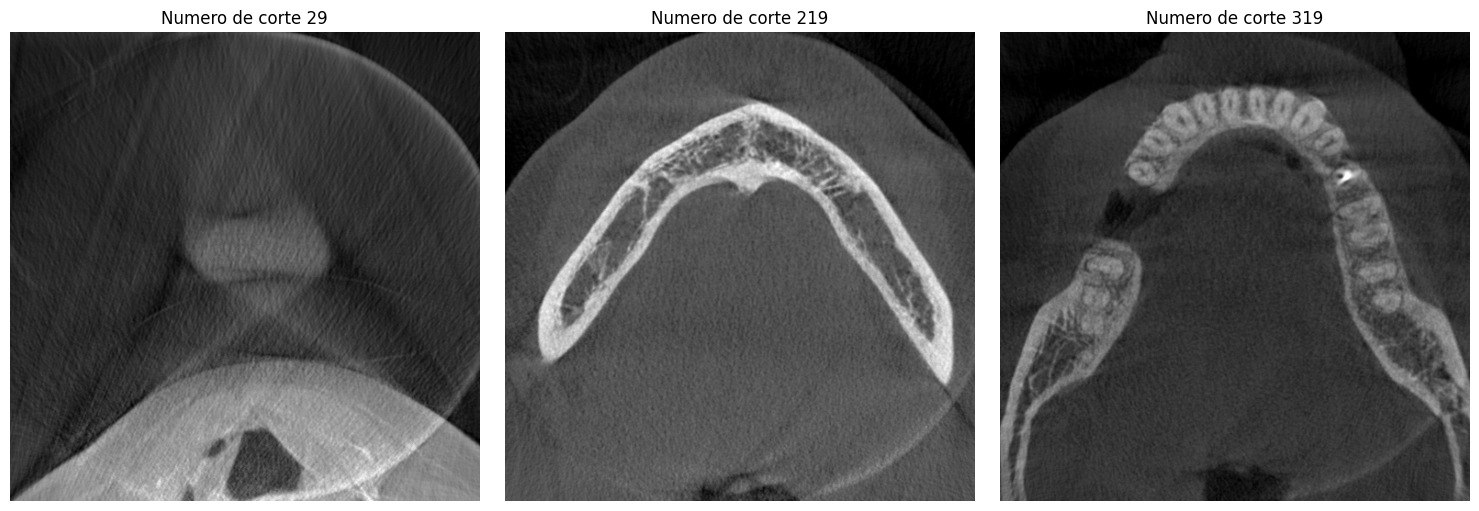

In [66]:
datasets = [ds, ds2, ds3]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (ax, dcm) in enumerate(zip(axs, datasets)):
    image = dcm.pixel_array
    ax.imshow(image, cmap='gray')
    corte = getattr(dcm, 'InstanceNumber', None)
    ax.set_title(f"Numero de corte {corte}")
    ax.axis('off')

plt.tight_layout()
plt.show()

<hr>
<h3><strong>2. Comparación multimodal de imágenes</strong></h3>

* Identificar la modalidad de cada imagen.

In [68]:
# Lista de rutas a las imágenes DICOM
rutas_dicom = [
    "Modalidad1/201/1.3.46.670589.11.45555.5.0.8860.2024062407351290058.dcm",
    "Modalidad2/ScalarVolume_13/IMG0001.dcm",
    "Modalidad3/ScalarVolume_27/IMG0036.dcm"
]

# Leer y mostrar la modalidad de cada imagen
for idx, ruta in enumerate(rutas_dicom, start=1):
    ds = pydicom.dcmread(ruta)
    modalidad = ds.get("Modality", "No disponible")
    print(f"Modalidad {idx}: {modalidad}")


Modalidad 1: MR
Modalidad 2: CR
Modalidad 3: CT


* Comparación 

    1. Calidad visual
    2. Resolucion numerica
    3. Diferencias de contraste percibidas

In [69]:
# Diccionario para guardar una sola entrada representativa por modalidad
metadata_imagenes = {
    'CR': {},
    'MR': {},
    'CT': {}
}

# Procesar archivos DICOM
for path in rutas_dicom:
    ds = pydicom.dcmread(path)
    mod = ds.get("Modality", "Otra")

    if mod not in metadata_imagenes:
        continue  

    if not metadata_imagenes[mod]: 
        metadata_imagenes[mod] = {
            "Shape": getattr(ds.pixel_array, "shape", "No disponible"),
            "PixelSpacing": ds.get("PixelSpacing", "No disponible"),
            "SliceThickness": ds.get("SliceThickness", "No disponible"),
            "ImageOrientationPatient": ds.get("ImageOrientationPatient", "No disponible"),
            "ImagePositionPatient": ds.get("ImagePositionPatient", "No disponible"),
            "KVP": ds.get("KVP", "No disponible"),
            "ExposureTime": ds.get("ExposureTime", "No disponible"),
            "EchoTime": ds.get("EchoTime", "No disponible"),
            "PhotometricInterpretation": ds.get("PhotometricInterpretation", "No disponible"),
            "WindowCenter": ds.get("WindowCenter", "No disponible"),
            "WindowWidth": ds.get("WindowWidth", "No disponible"),
            "PixelRepresentation": ds.get("PixelRepresentation", "No disponible"),
            "BitsStored": ds.get("BitsStored", "No disponible"),
            "BitsAllocated": ds.get("BitsAllocated", "No disponible"),
            "HighBit": ds.get("HighBit", "No disponible")
        }

# Lista completa de características a mostrar
caracteristicas = [
    "Shape", "PixelSpacing", "SliceThickness", "ImageOrientationPatient", "ImagePositionPatient",
    "KVP", "ExposureTime", "EchoTime", "PhotometricInterpretation", "WindowCenter",
    "WindowWidth", "PixelRepresentation", "BitsStored", "BitsAllocated", "HighBit"
]

# Construir tabla tipo DataFrame
tabla = {
    "Característica": caracteristicas,
    "CR": [metadata_imagenes['CR'].get(c, "No disponible") for c in caracteristicas],
    "MR": [metadata_imagenes['MR'].get(c, "No disponible") for c in caracteristicas],
    "CT": [metadata_imagenes['CT'].get(c, "No disponible") for c in caracteristicas],
}

tabla_comparacion = pd.DataFrame(tabla)
tabla_comparacion

,Característica,CR,MR,CT
0,Shape,"(2828, 2320)","(640, 640)","(512, 512)"
1,PixelSpacing,No disponible,"[0.4716981, 0.4716981]","[.399608615, .399608615]"
2,SliceThickness,1.0,4.0,1.0
3,ImageOrientationPatient,"[1, 0, 0, 0, 1, 0]","[0.9998723, -1.59611e-002, 7.28958e-004, 0, -4...","[.994881, -.101038, -.00190704, -.0015692, .00..."
4,ImagePositionPatient,"[0, 0, 0]","[-141.8852, 72.608, 145.6311]","[-90.4009, 168.451, 12.273]"
5,KVP,No disponible,No disponible,No disponible
6,ExposureTime,No disponible,No disponible,No disponible
7,EchoTime,No disponible,-1.0,No disponible
8,PhotometricInterpretation,MONOCHROME2,MONOCHROME2,MONOCHROME2
9,WindowCenter,62123.0,393.399994,-10.0


* Graficar las tres imagenes en un subplot 1x3 con matplotlib

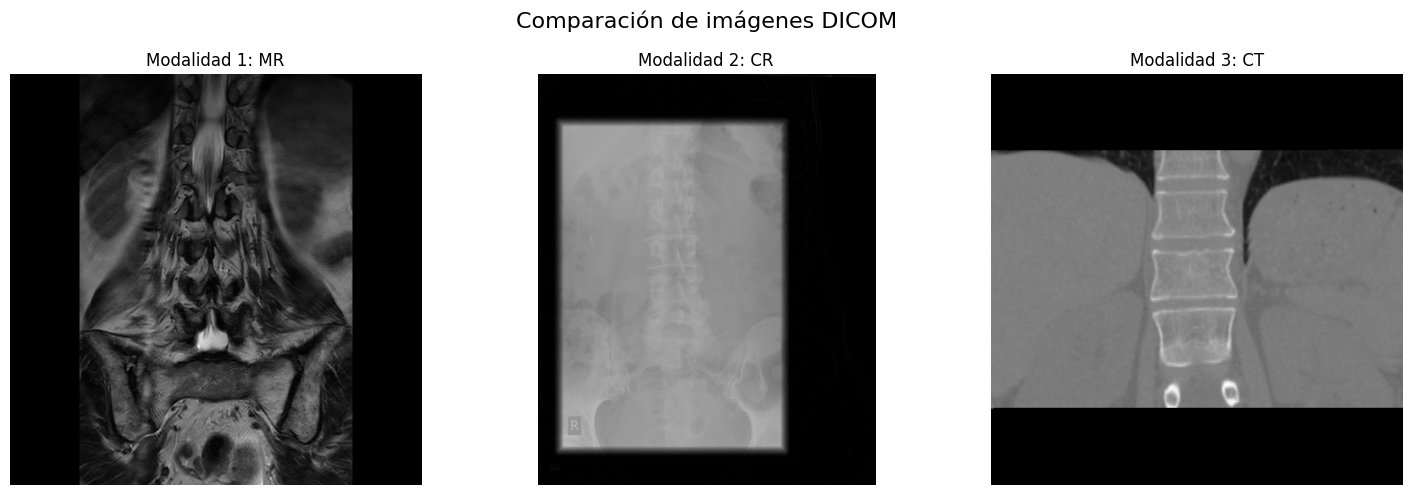

In [70]:
plt.figure(figsize=(15, 5))

# Recorrer y graficar cada imagen
for i, path in enumerate(rutas_dicom):
    ds = pydicom.dcmread(path)
    img = ds.pixel_array
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Modalidad {i + 1}: {ds.get('Modality', 'N/A')}")
    plt.axis('off')

# Título general
plt.suptitle("Comparación de imágenes DICOM", fontsize=16)
plt.tight_layout()
plt.show()

*  Incluir anotaciones y describir las diferencias encontradas. 

<hr>
<h3><strong>3. Simulación de flujo de información imagenológica </strong></h3>

* Diseñar un diagrama de flujo que represente el recorrido de una imagen médica desde su solicitud hasta la visualización e informe. 

![Texto alternativo](Diagrama_Flujo.png)